<a href="https://colab.research.google.com/github/Kenz2000/Projet-DATA2/blob/kenza_vf/Partie2(classic4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importations des librairies

In [ ]:
%%capture
! pip install umap-learn
! gdown 'https://drive.google.com/uc?id=1zTDcgnFtQWUeXgIce4O2Z2OPn0vJH1aD'
! pip install transformers

In [ ]:
from gensim.models import KeyedVectors
import numpy as np
import h5py as h5
import re
import pandas as pd
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import warnings
from umap import UMAP
from utils_py import accuracy
from wordcloud import WordCloud, STOPWORDS

/content/utils_py.py:167: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(sys.argv) is not 3:


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Importations et utilitaires

## Algorithme de clustering

In [ ]:
import os
import math
import numpy as np
import tensorflow.compat.v1 as tf
from sklearn.cluster import KMeans
from tqdm import tqdm

In [ ]:
TF_FLOAT_TYPE = tf.float32

tf.disable_eager_execution()

def fc_layers(input, specs):
    [dimensions, activations, names] = specs
    for dimension, activation, name in zip(dimensions, activations, names):
        input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)
    return input

def autoencoder(input, specs):
    [dimensions, activations, names] = specs
    mid_ind = int(len(dimensions)/2)

    # Encoder
    embedding = fc_layers(input, [dimensions[:mid_ind], activations[:mid_ind], names[:mid_ind]])
    # Decoder
    output = fc_layers(embedding, [dimensions[mid_ind:], activations[mid_ind:], names[mid_ind:]])

    return embedding, output

def f_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def g_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def next_batch(num, data):
    """
    Return a total of `num` random samples.
    """
    indices = np.arange(0, data.shape[0])
    np.random.shuffle(indices)
    indices = indices[:num]
    batch_data = np.asarray([data[i, :] for i in indices])

    return indices, batch_data

## Deep Clustering Network

In [ ]:
class DcnCompGraph(object):
    """Computation graph for the Deep Clustering Network model proposed in:
        Yang, B., Fu, X., Sidiropoulos, N. D., & Hong, M. (2017). Towards K-means-friendly Spaces: Simultaneous Deep
        Learning and Clustering. In ICML '17 (pp. 3861–3870).
    This implementation is inspired by https://github.com/boyangumn/DCN
    """

    def __init__(self, ae_specs, n_clusters, batch_size, n_samples, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0]) - 1) / 2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(batch_size, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g
        self.ae_loss = tf.reduce_mean(rec_error)

        # Clustering loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## Clustering assignments for all samples in the dataset
        initial_clustering_assign = tf.random_uniform(minval=0, maxval=n_clusters, dtype=tf.int32, shape=[n_samples])
        self.cluster_assign = tf.Variable(initial_clustering_assign, name='cluster_assign', dtype=tf.int32, trainable=False)

        ## Get the cluster representative corresponding to the cluster of each batch sample
        self.indices = tf.placeholder(dtype=tf.int32, shape=batch_size)  # Placeholder for sample indices in current batch
        batch_clust_rep = []
        for j in range(batch_size):
            k = self.cluster_assign[self.indices[j]]  # Clustering assignment for sample j in batch
            batch_clust_rep.append(self.cluster_rep[k, :])
        stack_batch_clust_rep = tf.stack(batch_clust_rep)

        ## Compute the k-means term
        clustering_error = f_func(self.embedding, stack_batch_clust_rep)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(clustering_error)
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DCN
        self.train_op = optimizer.minimize(self.loss)

        # As it has been pointed out in the DCN paper, first the weights of the autoencoder shall be trained then the
        # assignments and cluster representatives. So far in the computation graph we have optimized the weights of the
        # autoencoder, now it's the time for the assignments and representatives.

        # Update the clustering assignments
        for j in range(batch_size):
            # Find which cluster representative is the closest to the current batch sample
            new_assign = tf.argmin(f_func(tf.reshape(self.embedding[j, :], (1, embedding_size)), self.cluster_rep),
                                   output_type=tf.int32)
            # Update the clustering assignment
            self.cluster_assign_update = tf.assign(self.cluster_assign[self.indices[j]], new_assign)

        # Update the cluster representatives
        ## Initialize the value of count
        initial_count = tf.constant(100.0, shape=[n_clusters])
        count = tf.Variable(initial_count, name='count', dtype=TF_FLOAT_TYPE, trainable=False)
        ## Update the cluster representatives according to Equation (8) in the DCN paper
        for j in range(batch_size):
            k = self.cluster_assign[self.indices[j]]  # Clustering assignment for sample j in batch
            self.count_update = tf.assign(count[k], count[k] + 1)  # Updated count for cluster assignments
            new_rep = self.cluster_rep[k] - (1 / count[k]) * (self.cluster_rep[k] - self.embedding[j])
            self.cluster_rep_update = tf.assign(self.cluster_rep[k], new_rep)

In [ ]:
def DCN(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=50, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)

    cg = DcnCompGraph([dimensions, activations, names], n_clusters, batch_size, n_samples,
                      lambda_)

    # Run the computation graph
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):

                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices_, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                       feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices_)):
                        embeddings[indices_[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DCN
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

            # The clustering assignments are used to initialize the clustering assignments in DCN
            sess.run(tf.assign(cg.cluster_assign, kmeans_model.labels_))

        # Train the full DCN model
        print("Starting DCN training...")
        ## Loop over epochs
        for epoch in tqdm(range(n_finetuning_epochs)):
            # print("Training step: epoch {}".format(epoch))

            # Loop over the samples
            for _ in range(n_batches):
                # Fetch a random data batch of the specified size
                indices_, data_batch = next_batch(batch_size, data)

                # Run the computation graph on the data batch
                _, _, _, _, loss_, cluster_assign_, ae_loss_, kmeans_loss_ =\
                    sess.run((cg.train_op, cg.cluster_assign_update, cg.count_update, cg.cluster_rep_update, cg.loss,
                              cg.cluster_assign, cg.ae_loss, cg.kmeans_loss),
                             feed_dict={cg.input: data_batch, cg.indices: indices_})
        
        embeddings = np.zeros((n_samples, embedding_size), dtype=float)
        for _ in range(n_batches):
            # Fetch a random data batch of the specified size
            indices_, data_batch = next_batch(batch_size, data)

            # Run the computation graph on the data batch
            _, _, embeddings_, _, _, loss_, cluster_assign_, ae_loss_, kmeans_loss_ =\
                sess.run((cg.train_op, cg.cluster_assign_update, cg.embedding, cg.count_update, cg.cluster_rep_update, cg.loss,
                          cg.cluster_assign, cg.ae_loss, cg.kmeans_loss),
                          feed_dict={cg.input: data_batch, cg.indices: indices_})

            for j in range(len(indices_)):
                embeddings[indices_[j], :] = embeddings_[j, :]
                
    return embeddings, cluster_assign_


## Deep K-means

In [ ]:
class DkmCompGraph(object):
    """Computation graph for Deep K-Means
    """

    def __init__(self, ae_specs, n_clusters, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0])-1)/2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(None, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g

        # k-Means loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## First, compute the distance f between the embedding and each cluster representative
        list_dist = []
        for i in range(0, n_clusters):
            dist = f_func(self.embedding, tf.reshape(self.cluster_rep[i, :], (1, embedding_size)))
            list_dist.append(dist)
        self.stack_dist = tf.stack(list_dist)

        ## Second, find the minimum squared distance for softmax normalization
        min_dist = tf.reduce_min(list_dist, axis=0)

        ## Third, compute exponentials shifted with min_dist to avoid underflow (0/0) issues in softmaxes
        self.alpha = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=())  # Placeholder tensor for alpha
        list_exp = []
        for i in range(n_clusters):
            exp = tf.exp(-self.alpha * (self.stack_dist[i] - min_dist))
            list_exp.append(exp)
        stack_exp = tf.stack(list_exp)
        sum_exponentials = tf.reduce_sum(stack_exp, axis=0)

        ## Fourth, compute softmaxes and the embedding/representative distances weighted by softmax
        list_softmax = []
        list_weighted_dist = []
        for j in range(n_clusters):
            softmax = stack_exp[j] / sum_exponentials
            weighted_dist = self.stack_dist[j] * softmax
            list_softmax.append(softmax)
            list_weighted_dist.append(weighted_dist)
        stack_weighted_dist = tf.stack(list_weighted_dist)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(tf.reduce_sum(stack_weighted_dist, axis=0))
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DKM
        self.train_op = optimizer.minimize(self.loss) # Train the whole DKM model

In [ ]:
def DKM(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=5, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    """
        The final number of finetuning epochs is n_finetuning_epochs * 20 if pretrain and n_finetuning_epochs * 40 if annealing
    """
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained
    annealing = False # Specify if annealing should be used

    # Define the alpha scheme depending on if the approach includes annealing/pretraining
    if annealing and not pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 40  # Number of alpha values to consider
        alphas = np.zeros(max_n, dtype=float)
        alphas[0] = 0.1
        for i in range(1, max_n):
            alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
        alphas = alphas / constant_value
    elif not annealing and pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 20  # Number of alpha values to consider (constant values are used here)
        alphas = 1000*np.ones(max_n, dtype=float) # alpha is constant
        alphas = alphas / constant_value
    else:
        raise Exception("Run with either annealing (-a) or pretraining (-p), but not both.")

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)
    config = tf.ConfigProto(gpu_options=gpu_options)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)
      
    # Define the computation graph for DKM
    cg = DkmCompGraph([dimensions, activations, names], n_clusters, lambda_)

    # Run the computation graph
    with tf.Session(config=config) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Variables to save tensor content
        distances = np.zeros((n_clusters, n_samples))

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                        feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices)):
                        embeddings[indices[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DKM
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

        # Train the full DKM model
        if (len(alphas) > 0):
            print("Starting DKM training...")
        ## Loop over alpha (inverse temperature), from small to large values
        for k in tqdm(range(len(alphas))):
            # Loop over epochs per alpha
            for _ in range(n_finetuning_epochs):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph on the data batch
                    _, loss_, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
                        sess.run((cg.train_op, cg.loss, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                                  feed_dict={cg.input: data_batch, cg.alpha: alphas[k]})

                    # Save the distances for batch samples
                    for j in range(len(indices)):
                        distances[:, indices[j]] = stack_dist_[:, j]

        _, loss_, X_reduced, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
        sess.run((cg.train_op, cg.loss, cg.embedding, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                  feed_dict={cg.input: data, cg.alpha: alphas[k]})

        distances = stack_dist_

        # Infer cluster assignments for all samples
        cluster_assign = np.zeros((n_samples), dtype=float)
        for i in range(n_samples):
            index_closest_cluster = np.argmin(distances[:, i])
            cluster_assign[i] = index_closest_cluster
        cluster_assign = cluster_assign.astype(np.int64)

    return X_reduced, cluster_assign

# Chargement des données

In [ ]:
## classic4
! gdown "https://drive.google.com/uc?id=1270jrqfjC_j9jbujB8n6bTovnqCBG1Xp"
! gdown "https://drive.google.com/uc?id=1-0eXYefFHTliAuFfrRX8g2gnkYlF3Z5H"
! gdown "https://drive.google.com/uc?id=1-DAowc4ysRC9wDy60lzs8I6FIhLE4BEb"
! gdown "https://drive.google.com/uc?id=1-ckFmuejFrNGx0mbhqwNIhewCeuOfGxs"
! gdown "https://drive.google.com/uc?id=1vKduM6oCoGWWiXZrn1P33rnu74YbJJ2T"

Downloading...
From: https://drive.google.com/uc?id=1270jrqfjC_j9jbujB8n6bTovnqCBG1Xp
To: /content/classic4_word2vec.h5
100% 17.1M/17.1M [00:00<00:00, 73.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0eXYefFHTliAuFfrRX8g2gnkYlF3Z5H
To: /content/classic4_glove.h5
100% 17.1M/17.1M [00:00<00:00, 82.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-DAowc4ysRC9wDy60lzs8I6FIhLE4BEb
To: /content/classic4_bert.h5
100% 262M/262M [00:01<00:00, 183MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-ckFmuejFrNGx0mbhqwNIhewCeuOfGxs
To: /content/classic4_roberta.h5
100% 262M/262M [00:01<00:00, 168MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vKduM6oCoGWWiXZrn1P33rnu74YbJJ2T
To: /content/classic4.csv
100% 5.02M/5.02M [00:00<00:00, 139MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--FNn99G1Uut0R1v6mFqiuBi_pG-jC6o
To: /content/bbc_word2vec.h5
100% 2.70M/2.70M [00:00<00:00, 214MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-04KQb6ykG

In [ ]:
classic4_word2vec = pd.read_hdf("classic4_word2vec.h5").to_numpy()
classic4_glove = pd.read_hdf("classic4_glove.h5").to_numpy()
classic4_bert = pd.read_hdf("classic4_bert.h5").to_numpy()
classic4_roberta = pd.read_hdf("classic4_roberta.h5").to_numpy()

In [ ]:
classic4_texts = pd.read_csv("classic4.csv")["text"].values
classic4_labels = pd.read_csv("classic4.csv")["label"].values
k_classic4 = len(set(classic4_labels))

# Fonctions utilitaires

In [ ]:
def map_labels(labels):
    mapping = {}
    for (i,name) in enumerate(set(labels)):
        mapping[name] = i
    return [mapping[letter] for letter in labels]

In [ ]:
def eval_clustering_2D(x, labels, pred_labels, methods):
    fig, axes = plt.subplots(1, len(pred_labels)+1, figsize=(20,10))
    axes[0].scatter(x[:,0], x[:,1],
                    c=labels, edgecolor='none', alpha=1,)
    axes[0].title.set_text('Real Labels')
    nmis, aris, accs = {}, {}, {}
    for i in range(len(pred_labels)):
        nmi = normalized_mutual_info_score(labels, pred_labels[i])
        ari = adjusted_rand_score(labels, pred_labels[i])
        acc = accuracy(labels, pred_labels[i])
        nmis[methods[i]] = nmi
        aris[methods[i]] = ari
        accs[methods[i]] = acc
        axes[i+1].scatter(x[:,0], x[:,1],
                    c=pred_labels[i], edgecolor='none', alpha=1,)
        axes[i+1].title.set_text('{}\nNMI = {:.6f}\nARI={:.6f}\nACC={:.6f}'.format(methods[i], nmi, ari, acc))
    
    return nmis, aris, accs

In [ ]:
def run_methods(func, X, k, method_name, file_name, dataset, rep, ns = [2, 3, 5, 10, 20]):
  print(f'Executing of {method_name} method on the dataset: "{dataset}" with {rep} representation.')
  ALG_labels, ALG_methods = [], []
  for n_components in ns:
    print('Number of components:', n_components)
    alg_embeddings, alg_labels = func(X, k, n_components, seed=n_components)
    ALG_labels.append(alg_labels), ALG_methods.append(f'{method_name} - n_components = {n_components}')
    with h5.File(file_name, 'a') as alg_file:
      alg_file.create_dataset(f'{dataset}_default{n_components}components_embed_{rep}', data=alg_embeddings)
      alg_file.create_dataset(f'{dataset}_default{n_components}components_labels_{rep}', data=alg_labels)
  return ALG_labels, ALG_methods

In [ ]:
def print_wordcloud(X, labels):
    temp_df = pd.DataFrame({
        "text": X,
        "labels": labels
    })
    for label in temp_df['labels'].unique():
        alltext = ' '.join(temp_df[temp_df['labels']== label]['text'])
        wordcloud = WordCloud().generate(alltext)
        # Display the generated image:
        print(f'Class: {label}')
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        print(f'\n')

# Classic4 (approche jointe,simultanée)

In [ ]:
dataset = 'classic4'
k = k_classic4
labels = classic4_labels
classic4_resluts = {}

## La représentation Word2Vec

In [ ]:
X = classic4_word2vec
rep = 'word2vec'

### DCN (Deep Clustering network)

In [ ]:
file_name = './dcn_file1.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

Executing of DCN method on the dataset: "classic4" with word2vec representation.
Number of components: 2


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:08<00:00,  5.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Number of components: 3


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:06<00:00,  7.64it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:28<00:00,  1.72it/s]


Number of components: 5


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:06<00:00,  7.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


Number of components: 10


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:05<00:00,  9.20it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


Number of components: 20


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:05<00:00,  9.51it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


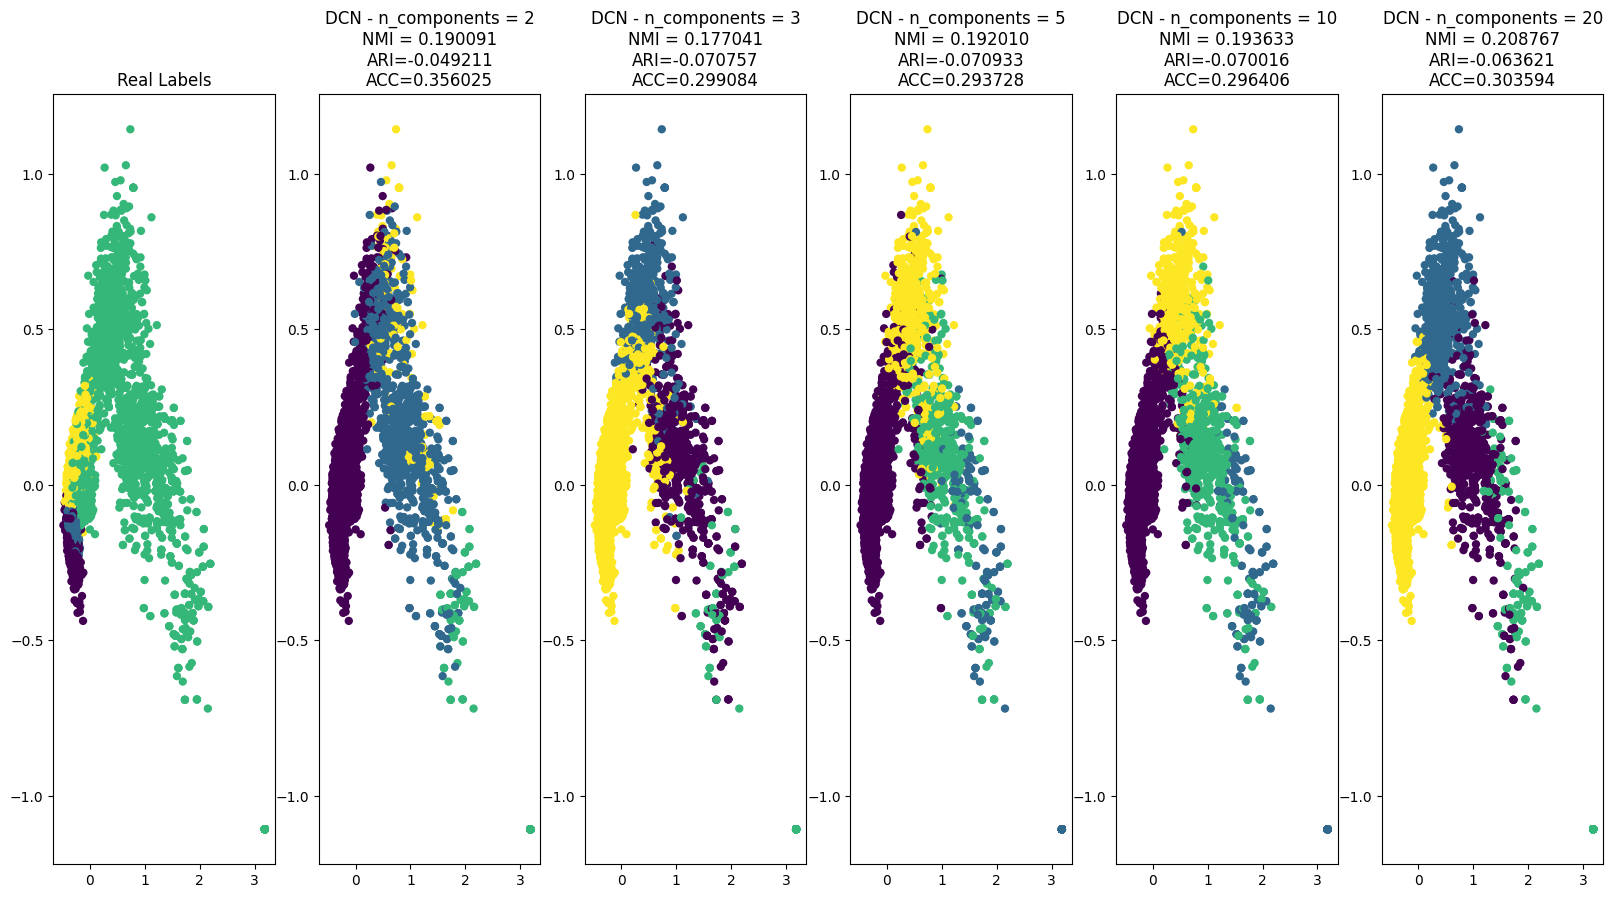

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

Lors de la visualisation de l'espace de représentation word2vec du dataset 'classic4' , il est clair que les clusters ne sont pas facilement séparables. En augmentant le nombre de composantes, la qualité de la classification ne s'améliore pas significativement. Les différentes combinaisons de la méthode DCN avec des nombres de composantes variables ne parviennent pas à séparer efficacement les classes dans leur espace d'origine, avec la plupart des estimations d'étiquettes se rapprochant d'une attribution aléatoire (ARI proche de 0 ou inférieur à 0).


In [ ]:
key = '{}_{}_dcn'.format(dataset, rep)
classic4_resluts[key] = (nmis, aris, accs)

### DKM (Deep K_means)

In [ ]:
file_name = './dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

Executing of DKM method on the dataset: "classic4" with word2vec representation.
Number of components: 2


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:05<00:00,  8.94it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Number of components: 3


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:06<00:00,  8.33it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Number of components: 5


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:06<00:00,  7.79it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


Number of components: 10


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:05<00:00,  8.47it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Number of components: 20


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:05<00:00,  8.56it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


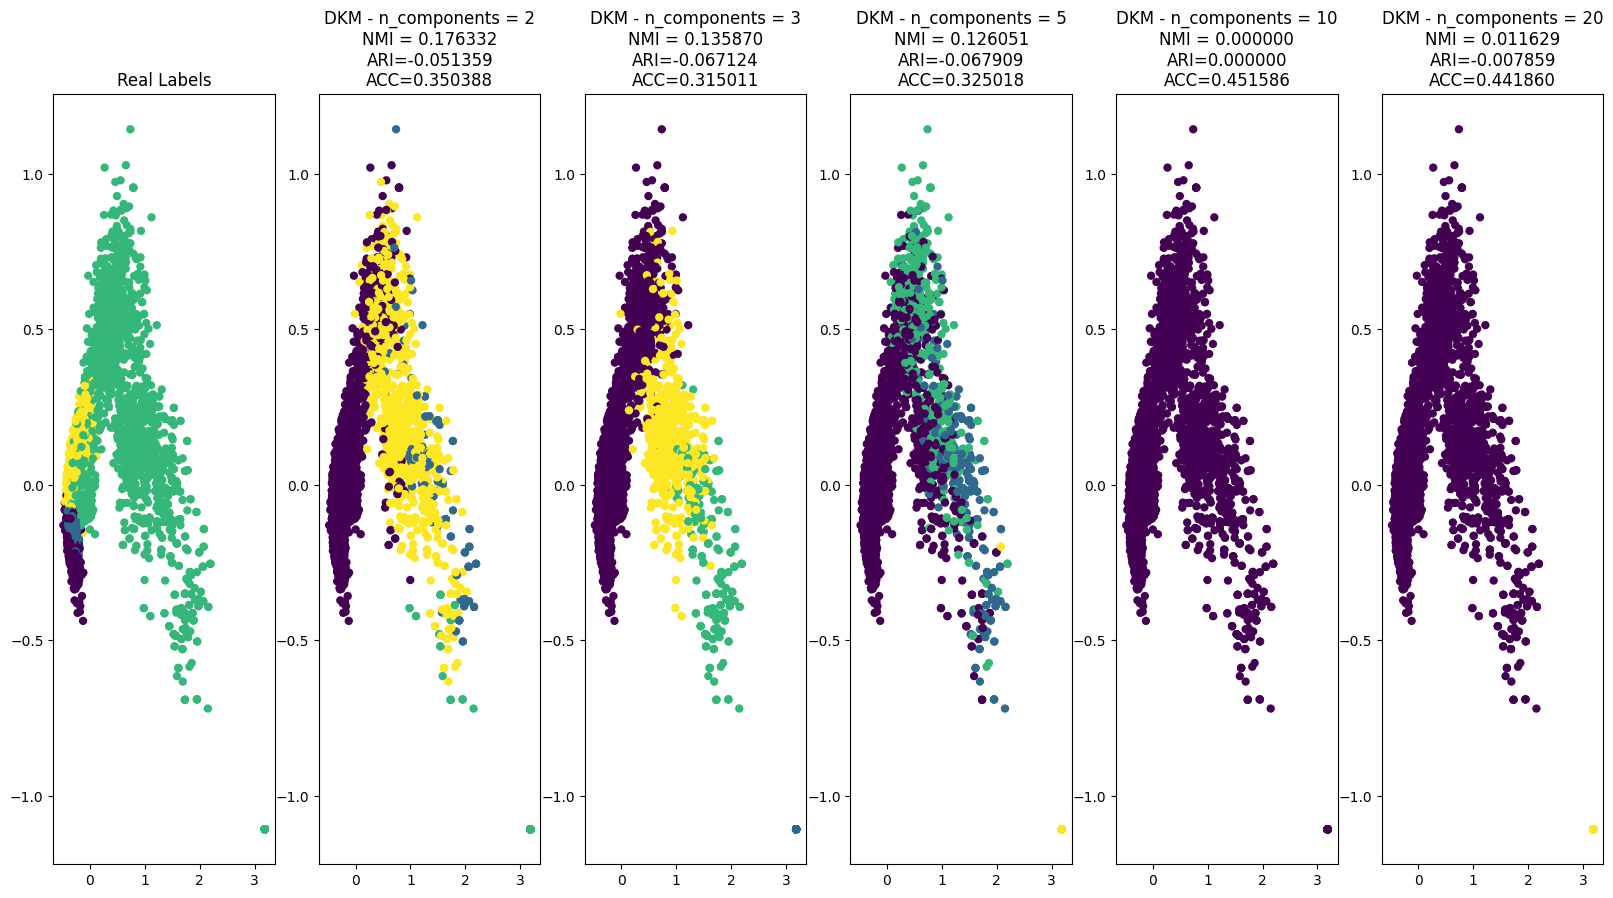

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

En utilisant la même représentation word2vec et en appliquant la méthode DKM avec différents nombres de composantes, il est observé que la classification obtenue avec 2 composantes présente des performances similaires à celles du DCN. Cependant, il est constaté qu'augmenter le nombre de composantes à chaque fois ne fait que détériorer les performances du clustering sur toutes les mesures évaluées.

In [ ]:
key = '{}_{}_dkm'.format(dataset, rep)
classic4_resluts[key] = (nmis, aris, accs)

## La représentation  GloVe

In [ ]:
X = classic4_glove
rep = 'GloVe'

###  DCN

In [ ]:
file_name = './dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

Executing of DCN method on the dataset: "classic4" with GloVe representation.
Number of components: 2


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:05<00:00,  9.02it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:28<00:00,  1.73it/s]


Number of components: 3


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:05<00:00,  8.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:29<00:00,  1.71it/s]


Number of components: 5


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:05<00:00,  9.57it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


Number of components: 10


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:07<00:00,  6.92it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


Number of components: 20


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:06<00:00,  7.41it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


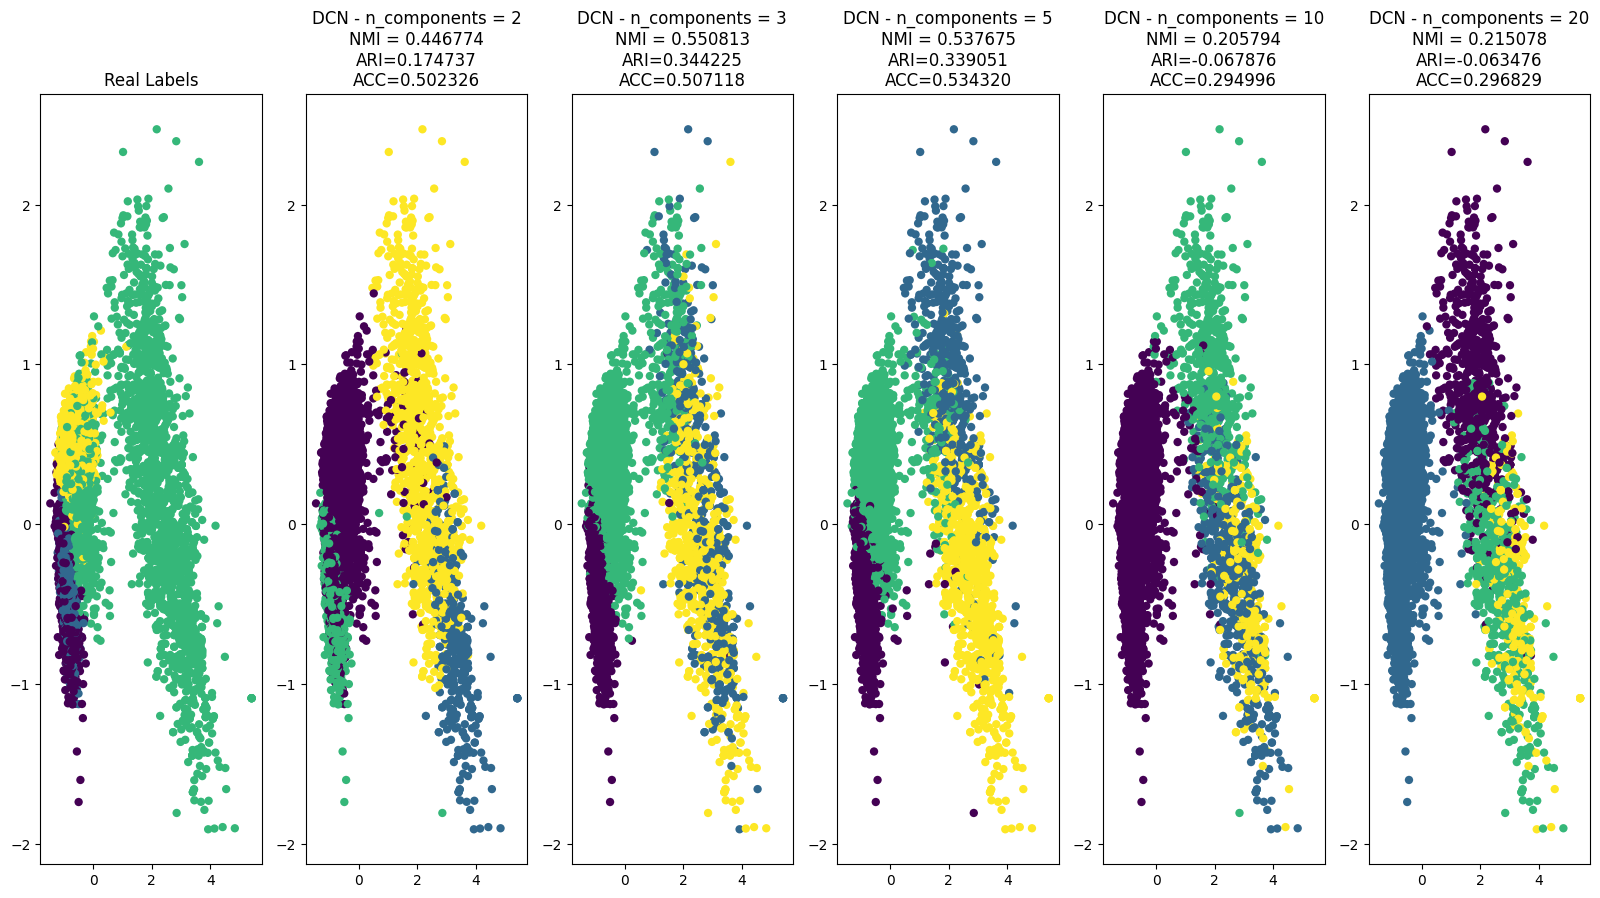

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

En observant la visualisation de l'espace de la représentation GloVe , on constate que les clusters ne sont pas facilement séparables. Cependant, à chaque augmentation du nombre de composantes, nous observons une amélioration de la qualité de notre clustering . Les différentes combinaisons de la méthode DCN avec différents nombres de composantes sont capables de mieux séparer les classes dans leur espace d'origine par rapport à ce que nous avons observé dans la représentation "word2vec". Cette observation est confirmée par la valeur de l'indice ARI, qui est généralement proche de 34% et NMI proche de 55% pour un nombre de composante égale à 3 .

In [ ]:
key = '{}_{}_dcn'.format(dataset, rep)
classic4_resluts[key] = (nmis, aris, accs)

### DKM

In [ ]:
file_name = './dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

Executing of DKM method on the dataset: "classic4" with GloVe representation.
Number of components: 2


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:06<00:00,  7.20it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Number of components: 3


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:06<00:00,  7.16it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Number of components: 5


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:06<00:00,  7.82it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Number of components: 10


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:05<00:00,  8.59it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Number of components: 20


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:05<00:00,  8.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


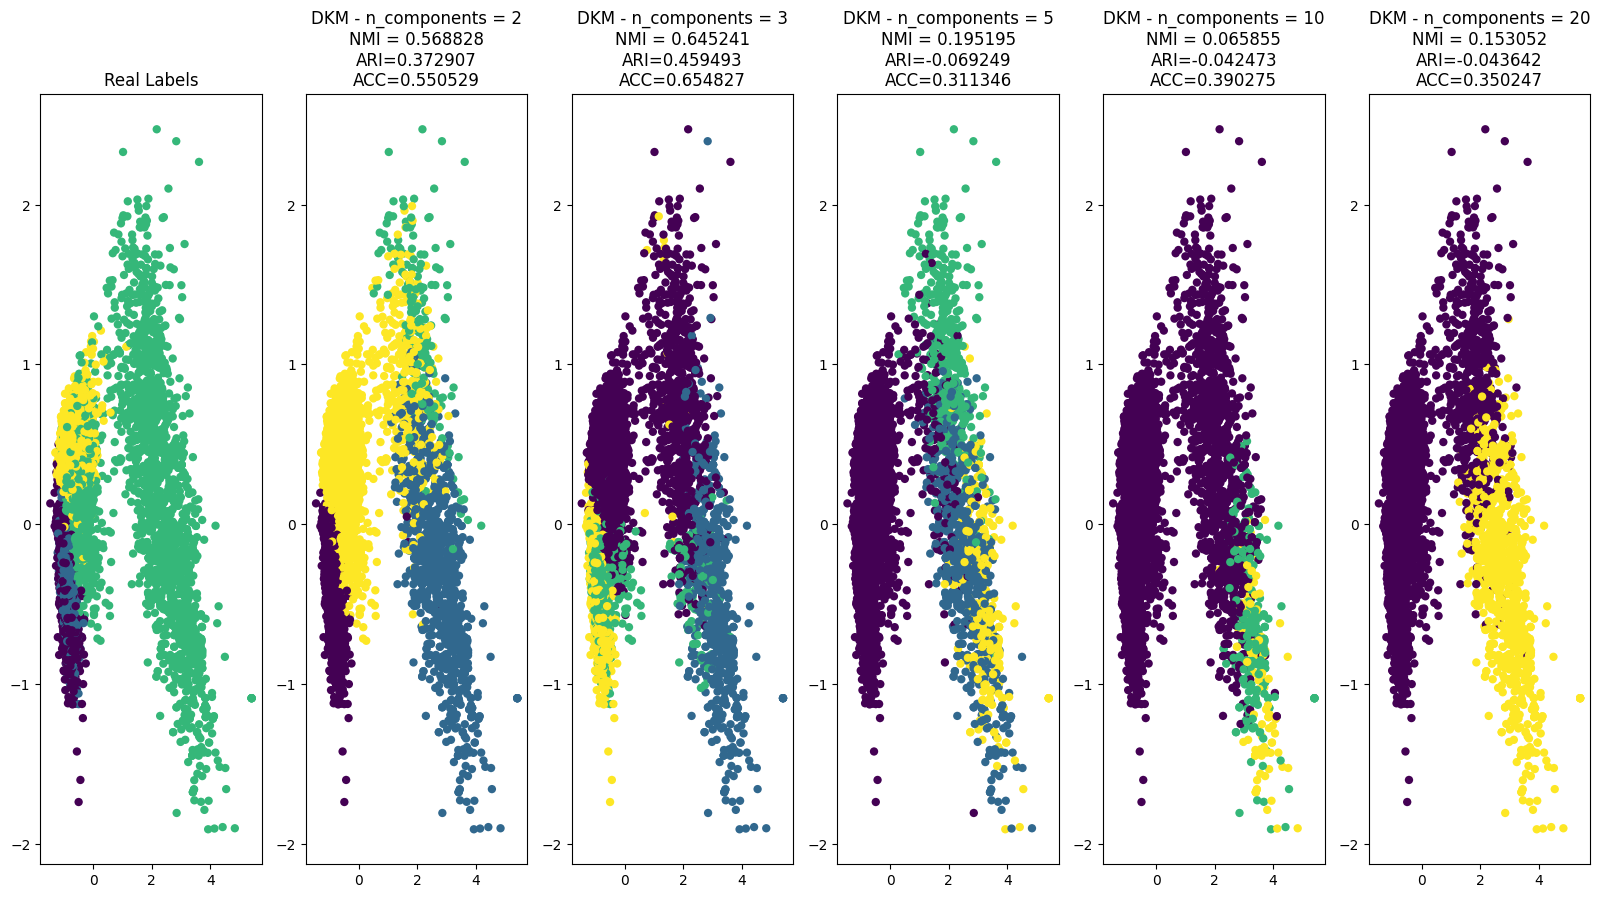

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

En utilisant la même représentation, il est observé que les différentes combinaisons de la méthode DKM avec différents nombres de composantes parviennent à bien séparer les classes dans leur espace d'origine. Un exemple remarquable de classification efficace dans ce jeu de données est obtenu avec un nombre de composantes égal à 3, comme en témoigne un ARI de 46%, un NMI de 64,5% et une accuarcy de 65%. Ces valeurs confirment la qualité de cette classification.


In [ ]:
key = '{}_{}_dkm'.format(dataset, rep)
classic4_resluts[key] = (nmis, aris, accs)

## La preprésentation Bert

In [ ]:
X = classic4_bert
rep = 'bert'

### DCN

In [ ]:
file_name = './dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

Executing of DCN method on the dataset: "classic4" with bert representation.
Number of components: 2


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:54<00:00,  1.09s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:15<00:00,  1.50s/it]


Number of components: 3


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:53<00:00,  1.07s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


Number of components: 5


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:54<00:00,  1.09s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


Number of components: 10


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:54<00:00,  1.10s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


Number of components: 20


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:55<00:00,  1.11s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


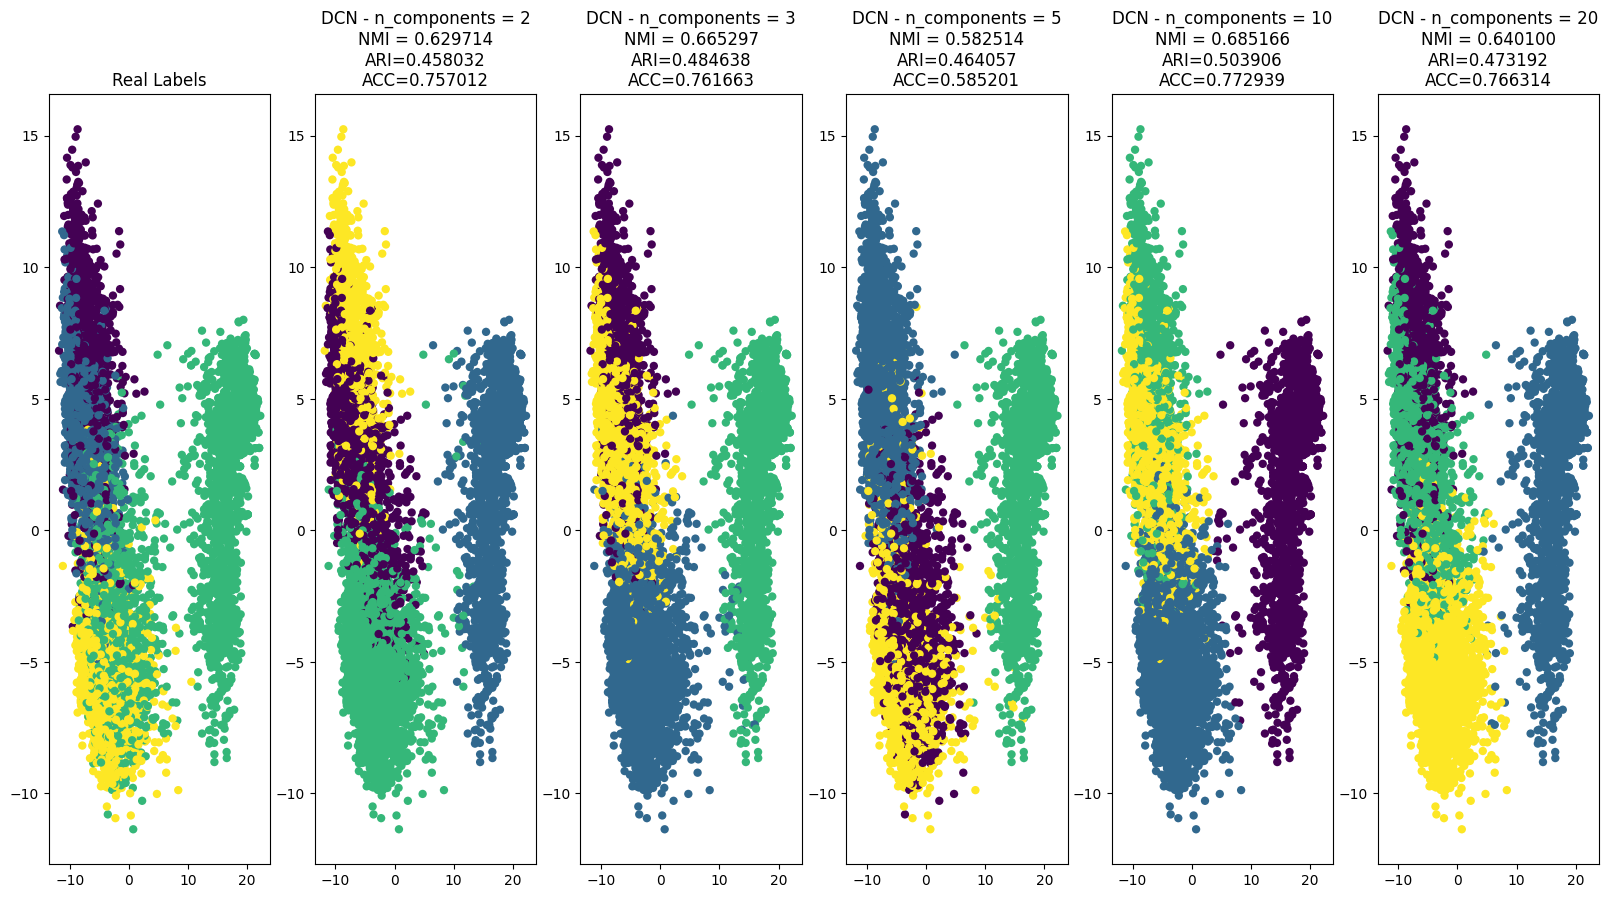

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

Lors de l'observation du dataset 'classic4' et en utilisant la représentation Bert, nous constatons que les clusters ne sont pas facilement distinguables dans l'espace réduit. Cependant, en augmentant le nombre de composantes, nous observons une amélioration notable et significative de la qualité de notre classification. Malgré cela, les différentes combinaisons de la méthode DCN avec différentes nombre de composantes ne parviennent pas à séparer efficacement les classes dans leur espace d'origine. Néanmoins, la plupart des résultats obtenus présentent une performance significative, avec une NMI de 68%, un ARI de 50% et une précision de 76%. Ces résultats sont considérés comme très bons par rapport aux représentations Glove et Word2Vec, pour lesquelles les performances étaient faibles et médiocres, sans amélioration significative en variant le nombre de composantes.


In [ ]:
key = '{}_{}_dcn'.format(dataset, rep)
classic4_resluts[key] = (nmis, aris, accs)

### DKM

In [ ]:
file_name = './dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

Executing of DKM method on the dataset: "classic4" with bert representation.
Number of components: 2


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:54<00:00,  1.08s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [01:55<00:00,  5.78s/it]


ResourceExhaustedError: ignored

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

In [ ]:
key = '{}_{}_dkm'.format(dataset, rep)
classic4_resluts[key] = (nmis, aris, accs)

## La représentation Roberta

In [ ]:
X = classic4_roberta
rep = 'roberta'

### DCN

In [ ]:
file_name = './dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

Executing of DCN method on the dataset: "classic4" with roberta representation.
Number of components: 2


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:57<00:00,  1.14s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


Number of components: 3


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:56<00:00,  1.13s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:18<00:00,  1.56s/it]


Number of components: 5


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


Number of components: 10


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:56<00:00,  1.14s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:20<00:00,  1.62s/it]


Number of components: 20


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:56<00:00,  1.13s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:19<00:00,  1.58s/it]


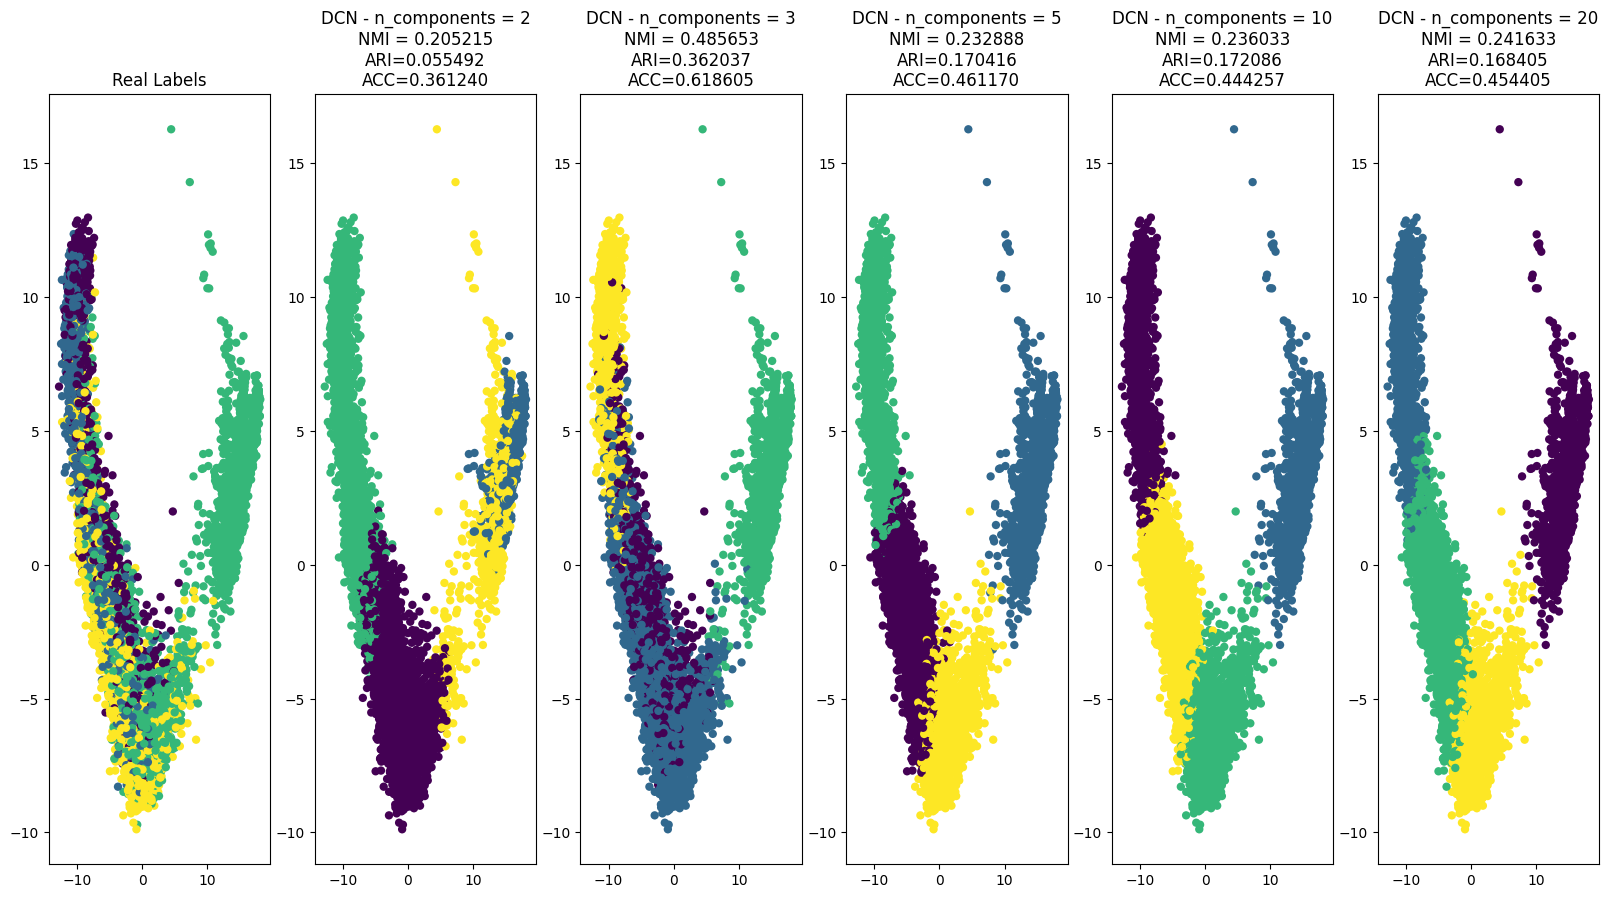

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

Lors de l'analyse de la dataset 'classic4' en utilisant la représentation Bert, la visualisation de l'espace montre que les clusters sont difficiles à distinguer. Cependant, en augmentant le nombre de composantes à 3, nous observons une nette amélioration de la qualité de notre clustering, avec un ARI de 36%, une NMI de 48% et une précision de 61.8%. Ces résultats sont significativement meilleurs que ceux obtenus avec un nombre de composantes de 2, qui étaient de 5% d'ARI, 20% de NMI et 36% de précision. Malgré cela, les différentes combinaisons de la méthode DCN avec des nombres de composantes variables ne parviennent pas à séparer efficacement les classes dans leur espace d'origine.

In [ ]:
key = '{}_{}_dcn'.format(dataset, rep)
classic4_resluts[key] = (nmis, aris, accs)

### DKM

In [ ]:
file_name = './dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

Executing of DKM method on the dataset: "classic4" with roberta representation.
Number of components: 2


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:57<00:00,  1.15s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [02:00<00:00,  6.00s/it]


ResourceExhaustedError: ignored

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

In [ ]:
key = '{}_{}_dkm'.format(dataset, rep)
classic4_resluts[key] = (nmis, aris, accs)

## Tableau des résultats

In [ ]:
with open("./classic4part2results.pkl", "wb") as results_file:
  pickle.dump(classic4_resluts, results_file)

In [ ]:
CLASSIC4_results = {key: {inkey: {'nmi': nmi[inkey],'ari': ari[inkey],'acc': acc[inkey]} for inkey in nmi.keys()}  for key, (nmi, ari, acc) in classic4_resluts.items()}
classic4_results_dataframe = pd.DataFrame.from_dict({(i,j): CLASSIC4_results[i][j] 
                           for i in CLASSIC4_results.keys() 
                           for j in CLASSIC4_results[i].keys()},
                       orient='index')
classic4_results_dataframe

nmi       ari       acc
classic4_word2vec_dcn DCN - n_components = 2   0.190091 -0.049211  0.356025
                      DCN - n_components = 3   0.177041 -0.070757  0.299084
                      DCN - n_components = 5   0.192010 -0.070933  0.293728
                      DCN - n_components = 10  0.193633 -0.070016  0.296406
                      DCN - n_components = 20  0.208767 -0.063621  0.303594
classic4_word2vec_dkm DKM - n_components = 2   0.176332 -0.051359  0.350388
                      DKM - n_components = 3   0.135870 -0.067124  0.315011
                      DKM - n_components = 5   0.126051 -0.067909  0.325018
                      DKM - n_components = 10  0.000000  0.000000  0.451586
                      DKM - n_components = 20  0.011629 -0.007859  0.441860
classic4_GloVe_dcn    DCN - n_components = 2   0.446774  0.174737  0.502326
                      DCN - n_components = 3   0.550813  0.344225  0.507118
                      DCN - n_components = 5   0.537675  0.339051  0.534320
                      DCN - n_components = 10  0.205794 -0.067876  0.294996
                      DCN - n_components = 20  0.215078 -0.063476  0.296829
classic4_GloVe_dkm    DKM - n_components = 2   0.568828  0.372907  0.550529
                      DKM - n_components = 3   0.645241  0.459493  0.654827
                      DKM - n_components = 5   0.195195 -0.069249  0.311346
                      DKM - n_components = 10  0.065855 -0.042473  0.390275
                      DKM - n_components = 20  0.153052 -0.043642  0.350247
classic4_bert_dcn     DCN - n_components = 2   0.629714  0.458032  0.757012
                      DCN - n_components = 3   0.665297  0.484638  0.761663
                      DCN - n_components = 5   0.582514  0.464057  0.585201
                      DCN - n_components = 10  0.685166  0.503906  0.772939
                      DCN - n_components = 20  0.640100  0.473192  0.766314
classic4_bert_dkm     DCN - n_components = 2   0.629714  0.458032  0.757012
                      DCN - n_components = 3   0.665297  0.484638  0.761663
                      DCN - n_components = 5   0.582514  0.464057  0.585201
                      DCN - n_components = 10  0.685166  0.503906  0.772939
                      DCN - n_components = 20  0.640100  0.473192  0.766314
classic4_roberta_dcn  DCN - n_components = 2   0.205215  0.055492  0.361240
                      DCN - n_components = 3   0.485653  0.362037  0.618605
                      DCN - n_components = 5   0.232888  0.170416  0.461170
                      DCN - n_components = 10  0.236033  0.172086  0.444257
                      DCN - n_components = 20  0.241633  0.168405  0.454405
classic4_roberta_dkm  DCN - n_components = 2   0.205215  0.055492  0.361240
                      DCN - n_components = 3   0.485653  0.362037  0.618605
                      DCN - n_components = 5   0.232888  0.170416  0.461170
                      DCN - n_components = 10  0.236033  0.172086  0.444257
                      DCN - n_components = 20  0.241633  0.168405  0.454405

In [ ]:
metric = "nmi"
classic4_results_dataframe[classic4_results_dataframe[metric] == classic4_results_dataframe[metric].max()]

nmi       ari       acc
classic4_bert_dcn DCN - n_components = 10  0.685166  0.503906  0.772939
classic4_bert_dkm DCN - n_components = 10  0.685166  0.503906  0.772939

In [ ]:
metric = "ari"
classic4_results_dataframe[classic4_results_dataframe[metric] == classic4_results_dataframe[metric].max()]

nmi       ari       acc
classic4_bert_dcn DCN - n_components = 10  0.685166  0.503906  0.772939
classic4_bert_dkm DCN - n_components = 10  0.685166  0.503906  0.772939

In [ ]:
metric = "acc"
classic4_results_dataframe[classic4_results_dataframe[metric] == classic4_results_dataframe[metric].max()]

nmi       ari       acc
classic4_bert_dcn DCN - n_components = 10  0.685166  0.503906  0.772939
classic4_bert_dkm DCN - n_components = 10  0.685166  0.503906  0.772939

Nous constatons que la représentation BERT est celle qui permet d'obtenir les meilleures performances, avec des scores supérieurs à 68% pour la NMI, 50% pour l'ARI et 77% pour l'accuracy. Ces résultats sont obtenus avec les deux modèles DCN en utilisant un nombre de composantes égal à 10.

DCN 5 composantes - BERT 

Class: 4


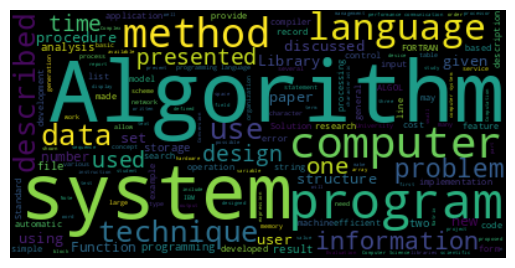



Class: 3


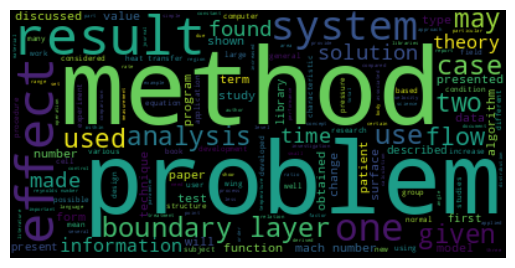



Class: 0


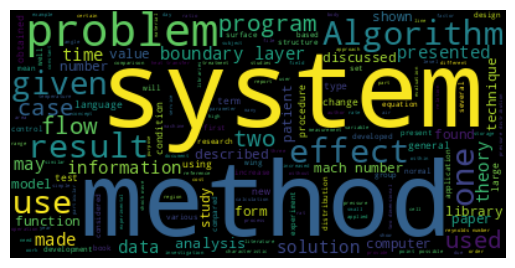

In [ ]:
file_name = './dcn_file.h5'
dataset, n_components, rep = 'classic4', 5, 'bert'
cluster_key = f'{dataset}_default{n_components}components_embed_{rep}'
with h5.File(file_name, 'r') as alg_file:
  best_labels = alg_file[cluster_key]
  print_wordcloud(classic4_texts, np.array(best_labels).argmax(axis=1))

DCN - 10 composantes - Bert

Class: 9


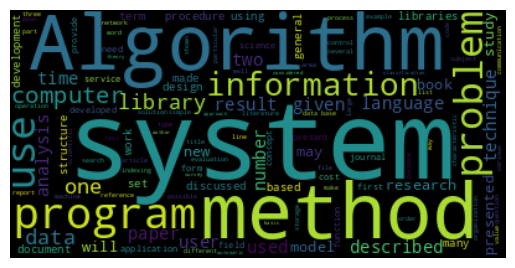



Class: 0


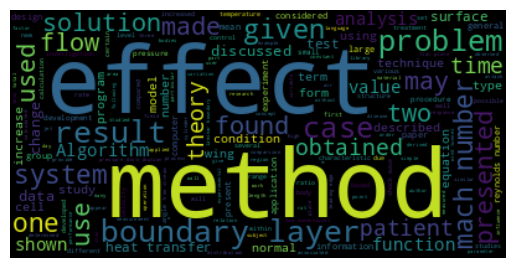



Class: 8


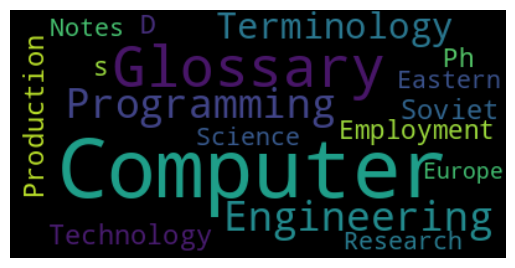

In [ ]:
file_name = './dcn_file.h5'
dataset, n_components, rep = 'classic4', 10, 'bert'
cluster_key = f'{dataset}_default{n_components}components_embed_{rep}'
with h5.File(file_name, 'r') as alg_file:
  best_labels = alg_file[cluster_key]
  print_wordcloud(classic4_texts, np.array(best_labels).argmax(axis=1))

Class: cacm


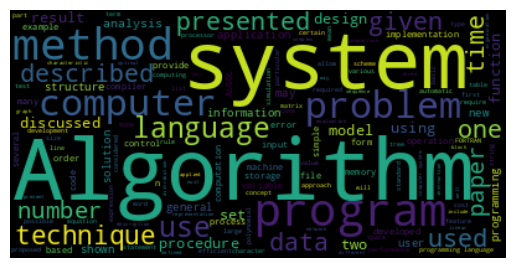



Class: cisi


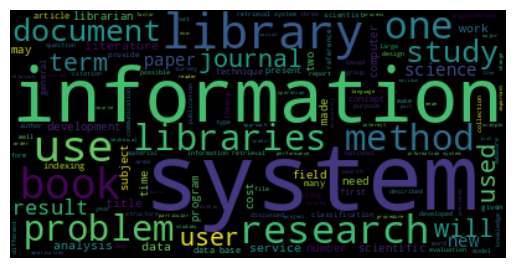



Class: med


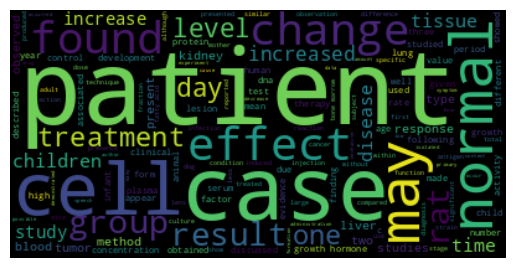



Class: cran


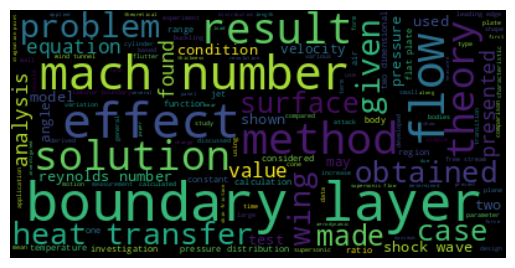

In [ ]:
print_wordcloud(classic4_texts, classic4_labels)

En comparant les nuages de mots, nous pouvons constater que la classe 0 est associée à la classe "cran", tandis que la classe 9 correspond à "cisi". Cette observation est basée sur la similarité des mots les plus fréquents entre les classes réelles et les classes prédites.